## Import packages

In [1]:
import pandas as pd
import gzip
import re
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import rushd as rd
from textwrap import wrap
from statannotations.Annotator import Annotator

import warnings
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)

## Make tx2gene maps

In [3]:
# Make tsv for converting transcript_id.version to gene_id.version
# Only need to run this block once to make the file

gtf_path = rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'Mus_musculus.GRCm39.114.chr.gtf.gz'

tx2gene_records = []
gene_name_map = {}

with gzip.open(gtf_path, 'rt') as f:
    for line in f:
        if line.startswith("#"): # skip the header lines
            continue
        parts = line.strip().split('\t')
        if len(parts) < 9: # ensure parts array is complete (expect length of 9)
            continue

        feature_type = parts[2] # gene, transcript, or exon
        attr_field = parts[8] # has info about gene_id, gene_version, gene_name, gene_source, and gene_biotype

        # Extract attributes using regex
        attrs = dict(re.findall(r'(\S+)\s+"([^"]+)"', attr_field))

        if feature_type == "transcript":
            transcript_id = attrs.get("transcript_id")
            gene_id = attrs.get("gene_id")

            transcript_version = attrs.get("transcript_version", "")
            gene_version = attrs.get("gene_version", "")

            if transcript_id and gene_id:
                tx_id_ver = f"{transcript_id}.{transcript_version}" if transcript_version else transcript_id
                gene_id_ver = f"{gene_id}.{gene_version}" if gene_version else gene_id
                tx2gene_records.append((tx_id_ver, gene_id_ver))

        if feature_type == "gene":
            gene_id = attrs.get("gene_id")
            gene_version = attrs.get("gene_version", "")
            gene_name = attrs.get("gene_name")

            if gene_id and gene_name:
                gene_id_ver = f"{gene_id}.{gene_version}" if gene_version else gene_id
                gene_name_map[gene_id_ver] = gene_name

# Save tx2gene
tx2gene_df = pd.DataFrame(tx2gene_records, columns=["transcript_id", "gene_id"])
tx2gene_df.to_csv(rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_tx2gene.tsv', sep="\t", index=False)

# Save gene_id → gene_name map
gene_name_df = pd.DataFrame(list(gene_name_map.items()), columns=["gene_id", "gene_name"])
gene_name_df.to_csv(rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_gene_id_to_name.tsv', sep="\t", index=False)

In [5]:
# Append ERCC tx2gene

# Load main tx2gene
tx2gene_path = rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_tx2gene.tsv'
tx2gene_df = pd.read_csv(tx2gene_path, sep="\t")
# Load ERCC tx2gene
ercc_tx2gene_path = rd.datadir/'RNA-seq'/'genomes'/'ERCC'/'ercc_tx2gene.tsv'
ercc_tx2gene_df = pd.read_csv(ercc_tx2gene_path, sep="\t")

# Combine, ensuring no duplicates
combined_tx2gene_df = pd.concat([tx2gene_df, ercc_tx2gene_df]).drop_duplicates()

# Save updated file
combined_tx2gene_df.to_csv(rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_with_ERCC_tx2gene.tsv', sep="\t", index=False)

## Load data

In [12]:
# Read sample sheet
samplesheet = pd.read_csv("config/samplesheet.csv")

# Extract replicate and cleaned condition
samplesheet["replicate"] = samplesheet["condition"].str.extract(r"_([A-Z])$")
samplesheet["condition"] = samplesheet["condition"].str.replace(r"_([A-Z])$", "", regex=True)
samplesheet["sample_name"] = samplesheet["condition"] + "_" + samplesheet["replicate"]
samplesheet = samplesheet.set_index("sample_name")

# File paths to quant.sf
quant_dir = rd.datadir/'RNA-seq'/'salmon_quantification'
samplesheet["quant_path"] = samplesheet.index.map(
    lambda sn: quant_dir / f"{sn}_GRCm39" / "quant.sf"
)
samplesheet.head()

,bmc_run,split_name,condition,replicate,quant_path
sample_name,,,,,
NIL_A,250425Gal,D25-170050,NIL,A,C:\Users\ChemeGrad2020\Downloads\zenoto\RNA-se...
SDD_A,250425Gal,D25-170051,SDD,A,C:\Users\ChemeGrad2020\Downloads\zenoto\RNA-se...
SDDIR_A,250425Gal,D25-170053,SDDIR,A,C:\Users\ChemeGrad2020\Downloads\zenoto\RNA-se...
RISDD_A,250425Gal,D25-170054,RISDD,A,C:\Users\ChemeGrad2020\Downloads\zenoto\RNA-se...
NIL_B,250425Gal,D25-170057,NIL,B,C:\Users\ChemeGrad2020\Downloads\zenoto\RNA-se...


In [13]:
# Read tx2gene mapping
tx2gene = pd.read_csv(rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_with_ERCC_tx2gene.tsv', sep="\t")
tx2gene_dict = dict(zip(tx2gene["transcript_id"], tx2gene["gene_id"]))

# Also read in gene_id_to_name map
gene_id_to_name = pd.read_csv(rd.datadir/'RNA-seq'/'genomes'/'GRCm39'/'GRCm39_gene_id_to_name.tsv', sep="\t")
gene_to_name_dict = dict(zip(gene_id_to_name["gene_id"], gene_id_to_name["gene_name"]))

# make metadata df from samplesheet
metadata = samplesheet[['condition','replicate']]

In [15]:
# Build gene-level count matrix from quant.sf files
def read_salmon_counts(quant_path, tx2gene):
    df = pd.read_csv(quant_path, sep="\t")
    df = df[df["Name"].isin(tx2gene)]
    df["gene_id"] = df["Name"].map(tx2gene)
    return df.groupby("gene_id")["NumReads"].sum()

# Generate count matrix
counts_dfs_dict = {  sample: read_salmon_counts(row["quant_path"], tx2gene_dict) for sample, row in samplesheet.iterrows()  } # dictionary of sample:counts_matrix
counts_df = pd.DataFrame(counts_dfs_dict).fillna(0).astype(int) # create dataframe, the keys (samples) become columns and the values (NumReads) become the column data

display(len(counts_df))

# Remove genes that are very lowly expressed (<10 total reads across all samples) to pre-filter genes
counts_df = counts_df[counts_df.sum(axis=1) > 0]

display(len(counts_df))

35695

22182

## Run DESeq2

In [16]:
# Split counts into ERCC and genes
is_ercc = counts_df.index.str.startswith("ERCC-")
counts_ercc = counts_df[is_ercc]
counts_genes = counts_df[~is_ercc]

ERCC_list = counts_ercc.index.to_list()

In [17]:
# Run DESeq2 on genes

dds = DeseqDataSet(
    counts=counts_genes.T,
    metadata=metadata,
    design="condition")

# Run DESeq2
dds.deseq2() # adds statistics to the dds object, which can be used to find differentially expressed genes

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 6.45 seconds.

Fitting dispersion trend curve...
... done in 0.78 seconds.

Fitting MAP dispersions...
... done in 9.55 seconds.

Fitting LFCs...
... done in 6.96 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 0 outlier genes.



## Plotting functions

In [18]:
outputdir = rd.rootdir/'figures'/'RNA_seq'
sns.set_theme(style="ticks",font_scale=1)

def custom_catplot(xcat,ycat,data,savetitle,hue=None,hue_order=None,height=4,width=8,
                   xlabel_rot=0,xlabel='',plottitle='',order=None,palette=None,pairs=None,color=None,log=False,reps=None,hlines=None):

    if hue == None:
        dodge = False
    elif hue != None:
        if hue == xcat:
            dodge = False
        else:
            dodge = 0.4

    plt.figure(figsize=(width,height))
    g = sns.pointplot(x=xcat,y=ycat,data=data,errorbar='se',join=False,capsize=0.22,
                      palette=palette,markers='_',scale=1.5,errwidth=1.5,order=order,hue=hue,color=color,dodge=dodge)
    ax = plt.gca()
    
    if order != None:
        #labels = [ '\n'.join(wrap(l, 16)) for l in order]
        labels = [ '\n'.join(l.split(' ')) for l in order]
    else:
        labels = None

    marker_list = ['o', '^', 's', 'D', 'P', 'X']
    if reps is not None:
        for (j, rep) in enumerate(data[reps].unique()):
            sns.stripplot(
                ax=ax, data=data[data[reps] == rep],
                x=xcat, y=ycat,
                order=order,
                hue=hue,
                hue_order=hue_order,
                dodge=dodge, marker=marker_list[j],
                #color='white',
                palette=palette,
                size=7,
                edgecolor='white', linewidth=0.4,
                legend=None)


    ymin, ymax = ax.get_ylim()
    if log == True:
        ax.set_yscale('log')
    elif ymax > 1000:
        plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    
    plt.ylim([0.75*data[ycat].min(),ymax*1.1])


    if pairs != None:
        annotator = Annotator(ax,pairs,data=data,x=xcat,y=ycat,order=order,hue=hue,hue_order=hue_order)
        annotator.configure(test='t-test_ind',text_format='star',loc='inside')
        annotator.apply_and_annotate()

    sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)        

    g.set_xticklabels(labels,rotation=xlabel_rot, horizontalalignment='center' if xlabel_rot==0 else 'right')

    if hlines:
        for h in hlines:
            plt.axhline(y=h, color='#cccccc', linestyle='--',zorder=-1)

    if hue == None:
        plt.legend([],[], frameon=False)
        plt.margins(x=0.3, y=0.3) # for some reason the plot is being weird and this makes it look better
    elif hue != None:
        if hue == xcat:
            plt.legend([],[], frameon=False)
        else:
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=False)
    
    plt.xlabel(xlabel)
    plt.ylabel(ycat)
    plt.title(plottitle)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.25) # make all plots have the same area
    #plt.tight_layout()
    plt.savefig(outputdir/str(savetitle + '.svg'),dpi=600)
    plt.show()


## Look at normed_counts for genes of interest

In [19]:
# Extract normalized counts from dds
normed_counts = pd.DataFrame(dds.layers['normed_counts'],
                             index=dds.obs_names, # sample names that correspond to metadata (condition_replicate)
                             columns=dds.var_names) # gene names

# merge with metadata to get condition and replicate columns
normed_counts = normed_counts.join(dds.obs[['condition', 'replicate']])

# rename Ensembl ID to the gene symbol
normed_counts_renamed = normed_counts.rename(columns=gene_to_name_dict)


In [20]:
# Export normed_counts for GEO upload

counts_export = normed_counts.drop(columns=['condition','replicate'])
counts_export = counts_export.T.reset_index()
counts_export = counts_export.rename_axis(None, axis=1)
counts_export = counts_export.rename(columns={'index': 'gene_id'})
counts_export['gene_symbol'] = counts_export['gene_id'].map(gene_to_name_dict)
counts_export.dropna(subset=['gene_symbol'], inplace=True)
order = ['gene_id','gene_symbol','NIL_A','NIL_B','NIL_C','SDD_A','SDD_B','SDD_C','RISDD_A','RISDD_B','RISDD_C','SDDIR_A','SDDIR_B','SDDIR_B']
counts_export = counts_export[order].copy()
display(counts_export)
counts_export.to_csv(rd.datadir/'RNA-seq'/'norm_counts'/'normalized_counts_all_samples.csv',index=False)


,gene_id,gene_symbol,NIL_A,NIL_B,NIL_C,SDD_A,SDD_B,SDD_C,RISDD_A,RISDD_B,RISDD_C,SDDIR_A,SDDIR_B,SDDIR_B
0,ENSMUSG00000000001.5,Gnai3,3590.387497,3630.642640,1508.427920,3224.439425,3265.716194,3191.763750,4883.072737,4927.209098,4678.268862,4372.713581,3896.736943,3896.736943
1,ENSMUSG00000000028.16,Cdc45,469.117015,373.946930,817.689886,793.332899,721.588796,846.416966,602.548404,492.930222,594.938594,767.297462,784.520048,784.520048
2,ENSMUSG00000000037.18,Scml2,44.637705,48.624678,31.987868,110.346450,110.396061,102.054796,16.630848,17.791537,23.797544,54.680969,29.558055,29.558055
3,ENSMUSG00000000049.12,Apoh,1.684442,2.315461,6.997346,2.323083,3.010802,1.913527,7.675776,2.093122,1.641210,0.881951,0.000000,0.000000
4,ENSMUSG00000000056.8,Narf,1136.155931,916.922503,729.723248,1094.172168,858.078471,884.049672,703.612786,559.910125,558.831976,654.407720,704.466982,704.466982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22086,ENSMUSG00000144222.1,Gm57848,213.924097,213.022400,520.802483,192.815902,226.813725,244.293668,381.230201,285.711148,292.955970,236.362896,258.632983,258.632983
22087,ENSMUSG00000144223.1,Tsc22d4,774.843185,716.635138,1202.543928,626.070912,631.264747,604.036825,703.612786,779.687931,808.295883,670.282840,956.942037,956.942037
22089,ENSMUSG00000144226.1,Gm51400,17.686638,19.681417,45.982561,22.069290,20.072011,22.324487,16.630848,20.931220,21.335729,18.520973,22.168541,22.168541
22105,ENSMUSG00000144287.1,Htd2,0.000000,12.735035,29.988627,0.000000,0.000000,47.838186,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### p53 target genes for NIL vs SDD, and SDDIR vs RISDD

In [21]:
apoptosis_GOI = ['Bbc3', # puma
                'Pmaip1', # noxa
                'Bax',
                'Apaf1',
                'Aen',
                'Pidd1',
                'Zmat3',
                'Fas',
                'Tnfrsf10b', # KILLER/DR5
                'Perp',
            ]

p53_senescence_GOI = [
                'Cdkn1a', # p21
                'Serpine1', # Pai-1
                'Pml',
                  ]

senescence_marker_GOI = [
                'Cdkn1a', # p21
                'Cdkn2a', # p16 / p19
                'Glb1', # SA beta-gal
                'Serpine1', # Pai-1
                'Serpine2', # PN-1
                'Pml',
                'Lmnb1', # Lamin B1, LOSS is associated with senescence
                  ]

growth_arrest_GOI = ['Cdkn1a', # p21
                     'Btg2',
                     'Gadd45a',
                     'Sfn', # 14-3-3-sigma
                     'Cav1',
                     'Ptprv',
                    ]

DNA_repair_GOI = ['Ddb2',
                  'Polk',
                  'Mgmt',
                  'Ercc5',
                  'Xpc',
                  'Rrm2b']


proliferation_GOI = ['Mki67','Pcna','Mcm2','Mcm6']


symbol_to_name = {'Cdkn1a':'p21', 
                  'Pmaip1':'Noxa',
                  'Bbc3':'Puma',
                  'Actb':'β-Actin',
                  'Cdkn2a':'p16',
                  'Cdkn2b':'p15',
                  'Cdkn2c':'p18',
                  'Glb1':'β-gal',
                  'Neurog2':'Ngn2',
                  'Bcl2l11':'Bim',
                  'Serpine1':'Pai-1',
                  'Serpine2':'PN-1',
                  'Serpinb2':'Pai-2',
                  'Cdkn1b':'p27',
                  'Cdkn1c':'p57',
                  'Tnfrsf10b':'Dr5'
                     }

GOI = [apoptosis_GOI,p53_senescence_GOI,senescence_marker_GOI,growth_arrest_GOI,DNA_repair_GOI,proliferation_GOI]
GOI_name = ['apoptosis_GOI','p53_senescence_GOI','senescence_marker_GOI','growth_arrest_GOI','DNA_repair_GOI','proliferation_GOI']


Found 10 out of 10: ['Bbc3', 'Pmaip1', 'Bax', 'Apaf1', 'Aen', 'Pidd1', 'Zmat3', 'Fas', 'Tnfrsf10b', 'Perp']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Perp_NIL vs. Perp_SDD: t-test independent samples, P_val:5.762e-02 t=2.639e+00
Dr5_NIL vs. Dr5_SDD: t-test independent samples, P_val:1.895e-02 t=3.809e+00
Noxa_NIL vs. Noxa_SDD: t-test independent samples, P_val:2.916e-01 t=1.214e+00
Puma_NIL vs. Puma_SDD: t-test independent samples, P_val:2.793e-01 t=1.251e+00
Bax_NIL vs. Bax_SDD: t-test independent samples, P_val:2.973e-02 t=3.307e+00
Apaf1_NIL vs. Apaf1_SDD: t-test independent samples, P_val:4.862e-01 t=7.663e-01
Aen_NIL vs. Aen_SDD: t-test independent samples, P_val:2.578e-03 t=6.703e+00
Pidd1_NIL vs. Pidd1_SDD: t-test independent samples, P_val:2.341e-02 t=3.568e+00
Zmat3_NIL vs. Zmat3_SDD: t-test independent samples, P_val:2.034e-03 

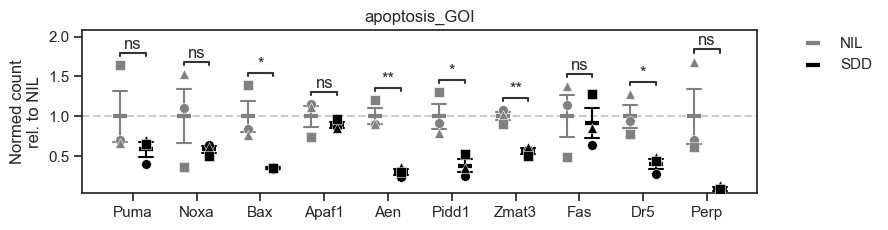

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Perp_SDDIR vs. Perp_RISDD: t-test independent samples, P_val:1.085e-02 t=-4.497e+00
Dr5_SDDIR vs. Dr5_RISDD: t-test independent samples, P_val:1.043e-04 t=-1.538e+01
Noxa_SDDIR vs. Noxa_RISDD: t-test independent samples, P_val:1.512e-02 t=-4.078e+00
Puma_SDDIR vs. Puma_RISDD: t-test independent samples, P_val:5.969e-02 t=-2.606e+00
Bax_SDDIR vs. Bax_RISDD: t-test independent samples, P_val:1.937e-03 t=-7.235e+00
Apaf1_SDDIR vs. Apaf1_RISDD: t-test independent samples, P_val:2.029e-03 t=-7.146e+00
Aen_SDDIR vs. Aen_RISDD: t-test independent samples, P_val:2.854e-04 t=-1.190e+01
Pidd1_SDDIR vs. Pidd1_RISDD: t-test independent samples, P_val:5.824e-01 t=-5.974e-01
Zmat3_SDDIR vs. Zmat3_RISDD: t-test independent samples, P_val:1.140e-03 t=-8.320e+00
Fas_SDDIR vs. Fas_RISDD: t-test independent samples, P_val:1.27

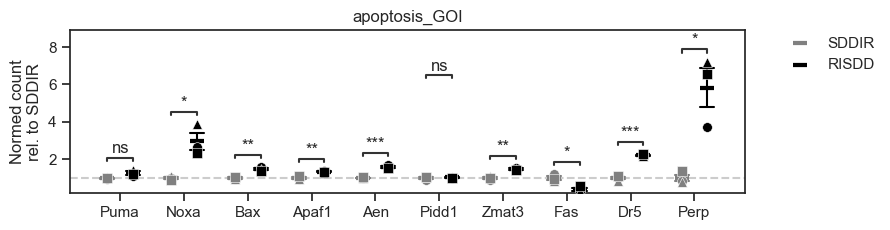

Found 3 out of 3: ['Cdkn1a', 'Serpine1', 'Pml']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pai-1_NIL vs. Pai-1_SDD: t-test independent samples, P_val:3.544e-01 t=1.046e+00
p21_NIL vs. p21_SDD: t-test independent samples, P_val:1.151e-04 t=1.500e+01
Pml_NIL vs. Pml_SDD: t-test independent samples, P_val:8.966e-01 t=1.385e-01


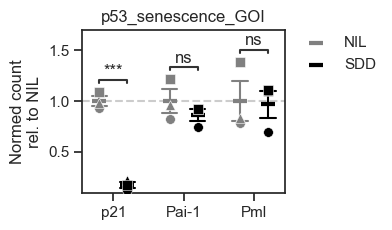

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pai-1_SDDIR vs. Pai-1_RISDD: t-test independent samples, P_val:1.314e-02 t=-4.252e+00
p21_SDDIR vs. p21_RISDD: t-test independent samples, P_val:8.666e-05 t=-1.612e+01
Pml_SDDIR vs. Pml_RISDD: t-test independent samples, P_val:1.025e-01 t=2.110e+00


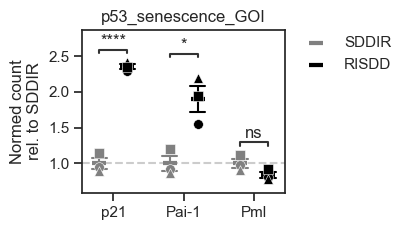

Found 7 out of 7: ['Cdkn1a', 'Cdkn2a', 'Glb1', 'Serpine1', 'Serpine2', 'Pml', 'Lmnb1']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p16_NIL vs. p16_SDD: t-test independent samples, P_val:7.692e-01 t=-3.140e-01
p21_NIL vs. p21_SDD: t-test independent samples, P_val:1.151e-04 t=1.500e+01
β-gal_NIL vs. β-gal_SDD: t-test independent samples, P_val:5.254e-03 t=5.521e+00
Pai-1_NIL vs. Pai-1_SDD: t-test independent samples, P_val:3.544e-01 t=1.046e+00
PN-1_NIL vs. PN-1_SDD: t-test independent samples, P_val:5.160e-03 t=5.549e+00
Pml_NIL vs. Pml_SDD: t-test independent samples, P_val:8.966e-01 t=1.385e-01
Lmnb1_NIL vs. Lmnb1_SDD: t-test independent samples, P_val:6.074e-02 t=-2.589e+00


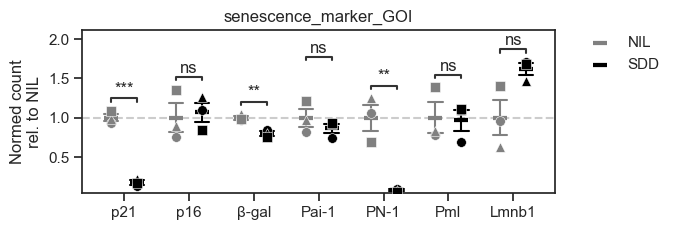

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p16_SDDIR vs. p16_RISDD: t-test independent samples, P_val:1.571e-01 t=1.738e+00
p21_SDDIR vs. p21_RISDD: t-test independent samples, P_val:8.666e-05 t=-1.612e+01
β-gal_SDDIR vs. β-gal_RISDD: t-test independent samples, P_val:6.767e-02 t=-2.487e+00
Pai-1_SDDIR vs. Pai-1_RISDD: t-test independent samples, P_val:1.314e-02 t=-4.252e+00
PN-1_SDDIR vs. PN-1_RISDD: t-test independent samples, P_val:1.802e-02 t=-3.868e+00
Pml_SDDIR vs. Pml_RISDD: t-test independent samples, P_val:1.025e-01 t=2.110e+00
Lmnb1_SDDIR vs. Lmnb1_RISDD: t-test independent samples, P_val:2.384e-02 t=3.548e+00


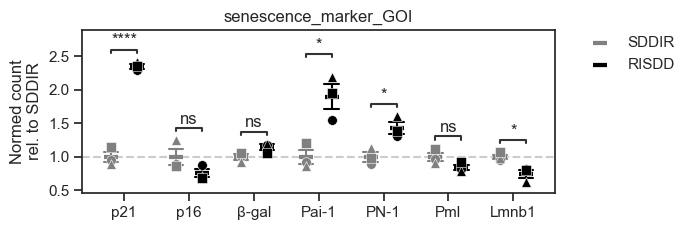

Found 6 out of 6: ['Cdkn1a', 'Btg2', 'Gadd45a', 'Sfn', 'Cav1', 'Ptprv']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Btg2_NIL vs. Btg2_SDD: t-test independent samples, P_val:3.811e-03 t=-6.031e+00
p21_NIL vs. p21_SDD: t-test independent samples, P_val:1.151e-04 t=1.500e+01
Gadd45a_NIL vs. Gadd45a_SDD: t-test independent samples, P_val:1.019e-02 t=4.580e+00
Sfn_NIL vs. Sfn_SDD: t-test independent samples, P_val:2.483e-01 t=1.350e+00
Cav1_NIL vs. Cav1_SDD: t-test independent samples, P_val:6.371e-03 t=-5.233e+00
Ptprv_NIL vs. Ptprv_SDD: t-test independent samples, P_val:2.063e-03 t=7.114e+00


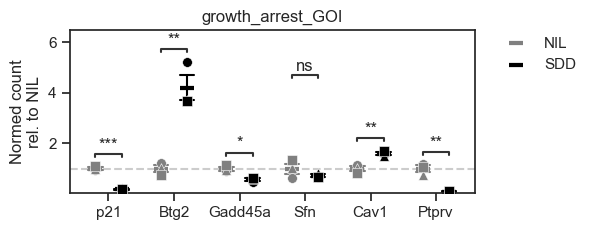

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Btg2_SDDIR vs. Btg2_RISDD: t-test independent samples, P_val:3.412e-01 t=1.079e+00
p21_SDDIR vs. p21_RISDD: t-test independent samples, P_val:8.666e-05 t=-1.612e+01
Gadd45a_SDDIR vs. Gadd45a_RISDD: t-test independent samples, P_val:7.404e-03 t=5.016e+00
Sfn_SDDIR vs. Sfn_RISDD: t-test independent samples, P_val:4.481e-02 t=-2.885e+00
Cav1_SDDIR vs. Cav1_RISDD: t-test independent samples, P_val:3.728e-04 t=1.111e+01
Ptprv_SDDIR vs. Ptprv_RISDD: t-test independent samples, P_val:5.210e-01 t=7.026e-01


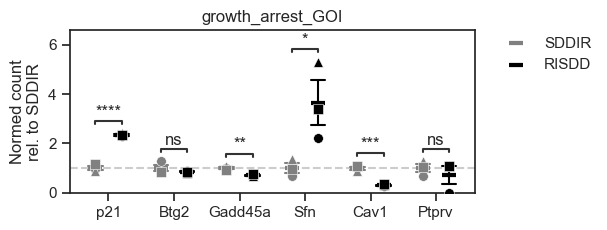

Found 6 out of 6: ['Ddb2', 'Polk', 'Mgmt', 'Ercc5', 'Xpc', 'Rrm2b']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Polk_NIL vs. Polk_SDD: t-test independent samples, P_val:9.722e-02 t=2.157e+00
Ddb2_NIL vs. Ddb2_SDD: t-test independent samples, P_val:1.854e-01 t=-1.597e+00
Mgmt_NIL vs. Mgmt_SDD: t-test independent samples, P_val:1.885e-03 t=7.287e+00
Ercc5_NIL vs. Ercc5_SDD: t-test independent samples, P_val:2.666e-02 t=3.425e+00
Xpc_NIL vs. Xpc_SDD: t-test independent samples, P_val:4.868e-02 t=2.803e+00
Rrm2b_NIL vs. Rrm2b_SDD: t-test independent samples, P_val:9.427e-01 t=7.654e-02


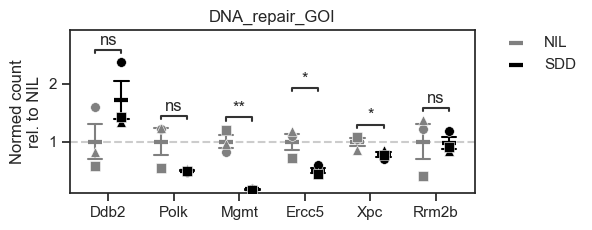

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Polk_SDDIR vs. Polk_RISDD: t-test independent samples, P_val:6.366e-02 t=-2.545e+00
Ddb2_SDDIR vs. Ddb2_RISDD: t-test independent samples, P_val:1.115e-01 t=2.035e+00
Mgmt_SDDIR vs. Mgmt_RISDD: t-test independent samples, P_val:2.333e-02 t=-3.572e+00
Ercc5_SDDIR vs. Ercc5_RISDD: t-test independent samples, P_val:7.721e-02 t=-2.365e+00
Xpc_SDDIR vs. Xpc_RISDD: t-test independent samples, P_val:1.228e-02 t=-4.337e+00
Rrm2b_SDDIR vs. Rrm2b_RISDD: t-test independent samples, P_val:3.153e-01 t=-1.147e+00


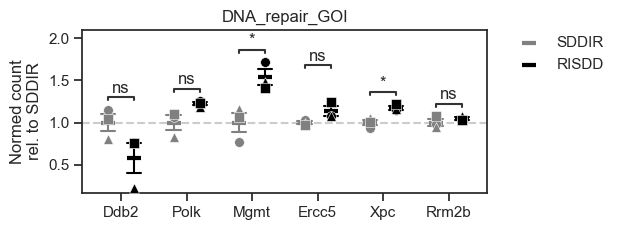

Found 4 out of 4: ['Mki67', 'Pcna', 'Mcm2', 'Mcm6']
Missing: []
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pcna_NIL vs. Pcna_SDD: t-test independent samples, P_val:5.314e-03 t=-5.504e+00
Mki67_NIL vs. Mki67_SDD: t-test independent samples, P_val:1.278e-03 t=-8.074e+00
Mcm2_NIL vs. Mcm2_SDD: t-test independent samples, P_val:8.082e-01 t=2.594e-01
Mcm6_NIL vs. Mcm6_SDD: t-test independent samples, P_val:1.376e-02 t=-4.195e+00


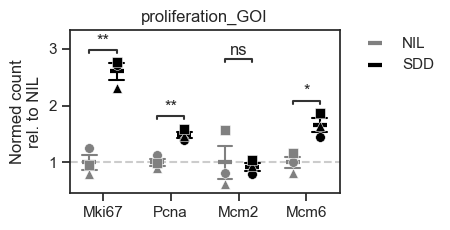

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pcna_SDDIR vs. Pcna_RISDD: t-test independent samples, P_val:3.631e-02 t=3.098e+00
Mki67_SDDIR vs. Mki67_RISDD: t-test independent samples, P_val:1.079e-02 t=4.504e+00
Mcm2_SDDIR vs. Mcm2_RISDD: t-test independent samples, P_val:3.212e-02 t=3.225e+00
Mcm6_SDDIR vs. Mcm6_RISDD: t-test independent samples, P_val:1.593e-03 t=7.619e+00


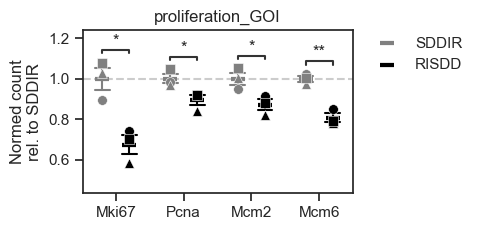

In [22]:

hue_order_list = [['NIL','SDD'],['SDDIR','RISDD']]
palette = {'NIL':'grey','SDD':'black',
           'SDDIR':'grey','RISDD':'black'}

for gene_list, gene_list_name in zip(GOI, GOI_name):

    available_genes = [gene for gene in gene_list if gene in normed_counts_renamed.columns]
    print(f"Found {len(available_genes)} out of {len(gene_list)}:", available_genes)
    print(f"Missing:",list(set(gene_list) - set(available_genes)))

    # Reshape to long format for plotting
    plot_df = normed_counts_renamed[available_genes + ['condition', 'replicate']].melt(
        id_vars=['condition', 'replicate'],
        var_name='symbol',
        value_name='normed_count')

    # Add gene name from gene symbol
    plot_df['gene'] = plot_df['symbol'].map(symbol_to_name).fillna(plot_df['symbol'])

    gene_order = plot_df.gene.unique().tolist()

    for hue_order in hue_order_list:

        pairs = [((cond, hue_order[0]), (cond, hue_order[1])) for cond in gene_order]
        
        # Get only the desired conditions
        plot_gene_df = plot_df[plot_df['condition'].isin(hue_order)].copy()

        # Normalize to the first condition in hue_order
        slice = plot_gene_df.drop(columns=['replicate','symbol'])
        means = slice.groupby(['condition','gene']).mean()
        means.reset_index(drop=False,inplace=True) # Remove index
        for gene in gene_order:
            norm_row = means[(means.condition == hue_order[0]) & (means.gene == gene)]        
            plot_gene_df.loc[(plot_gene_df.gene == gene),f'Normed count\nrel. to {hue_order[0]}'] = plot_gene_df.loc[
                            (plot_gene_df.gene == gene),'normed_count'] / norm_row['normed_count'].values[0]

        plottitle = gene_list_name
        savetitle = f"{hue_order[0]}_vs_{hue_order[1]}_{gene_list_name}"
        custom_catplot('gene',f'Normed count\nrel. to {hue_order[0]}',plot_gene_df,savetitle,
                        plottitle=plottitle,
                        height=2.5,
                        width=0.9*len(gene_order),
                        order=gene_order,
                        hue='condition',
                        hue_order=hue_order,
                        reps='replicate',
                        xlabel_rot=0,
                        palette=palette,
                        pairs=pairs,hlines=[1])